In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind, norm


ayu_colors = {
    "axes.facecolor": "#1F2430",  # фон графика
    "figure.facecolor": "#1F2430",  # фон фигуры
    "text.color": "#CBCCC6",  # цвет текста
    "axes.labelcolor": "#CBCCC6",  # цвет подписей осей
    "xtick.color": "#707A8C",  # цвет делений оси X
    "ytick.color": "#707A8C",  # цвет делений оси Y
    "grid.color": "#232834",  # цвет сетки
    "axes.prop_cycle": plt.cycler(
        color=["#8dd3c7", "#feffb3", "#bfbbd9", "#fa8174", "#81b1d2"]
    ),  # цвета линий как в dark_background
}

plt.rcParams.update(ayu_colors)


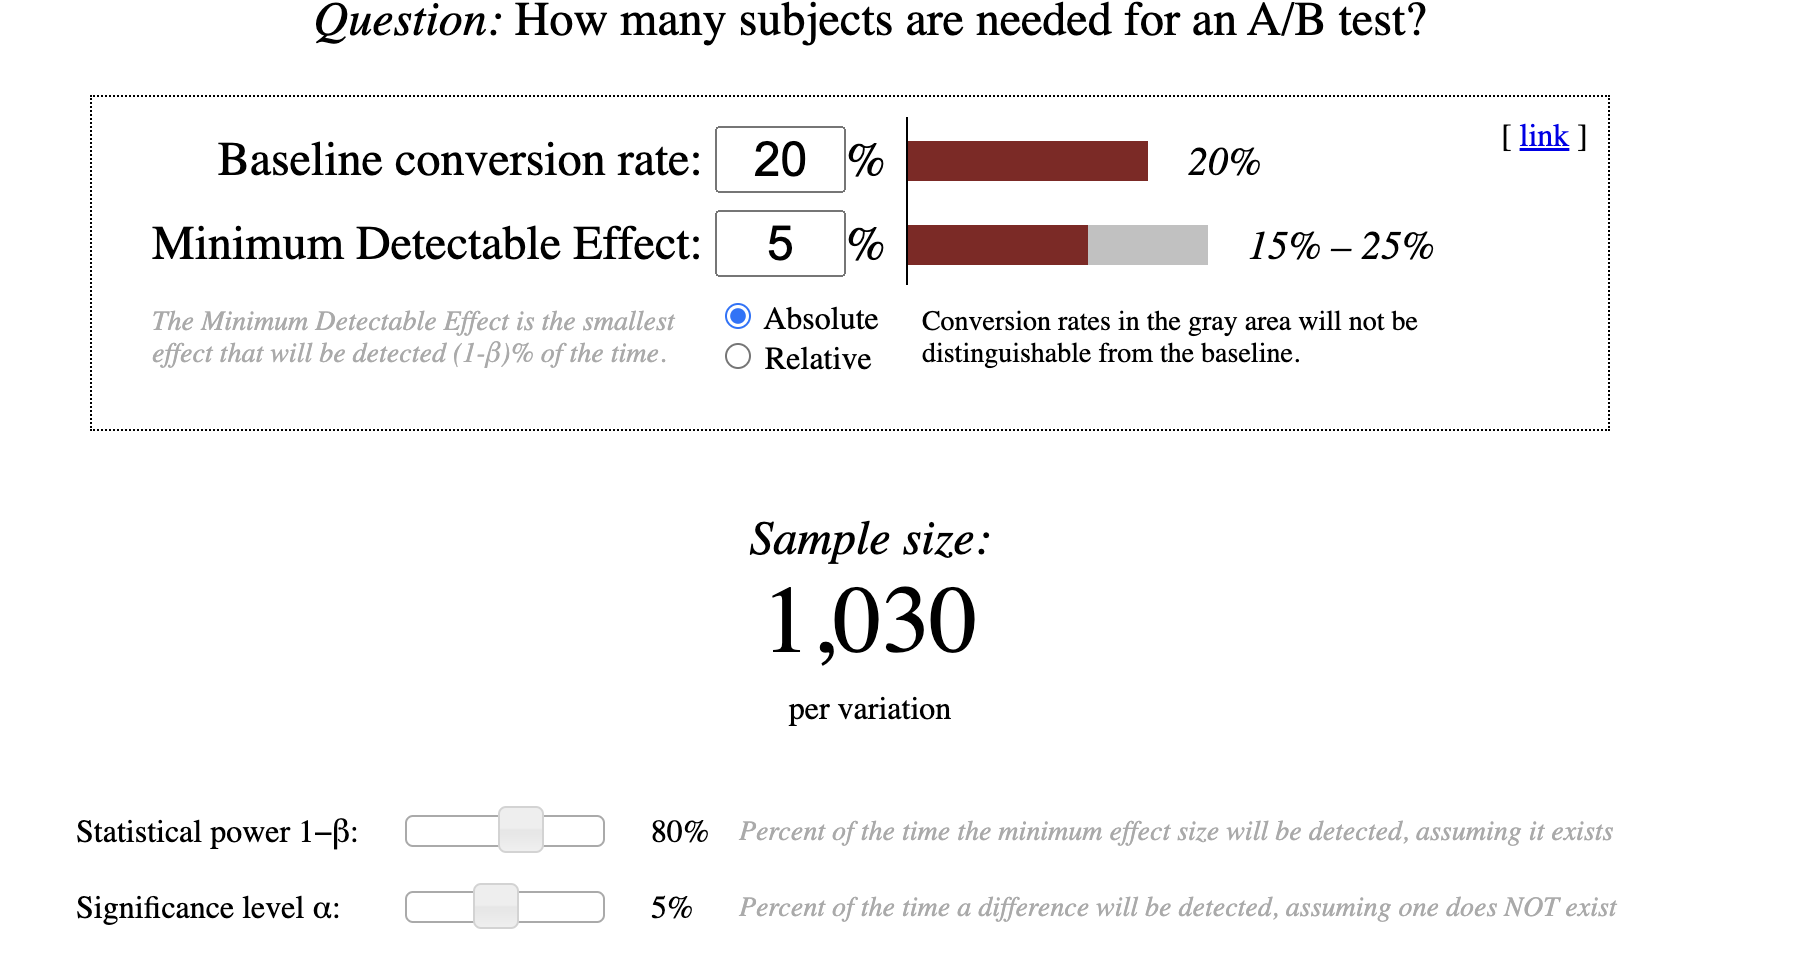

In [2]:
mde = 0.05
baseline = 0.2
sample_size = 1030

In [3]:
a = np.random.binomial(1, baseline, size=sample_size)

In [4]:
b = np.random.binomial(1, baseline + mde, size=sample_size)

На этих данных можно проводить следующие тесты: \
- Fisher exact test
- Z test == Chi square test
- T test
- Bootstrap (Monte-Carlo)

H0: разницы между группами нет(группы пришли из одного распределения)

In [5]:
result = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde, size=sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
t = pd.Series(result)

In [7]:
(t < 0.05).mean()

np.float64(0.7799)

<Axes: >

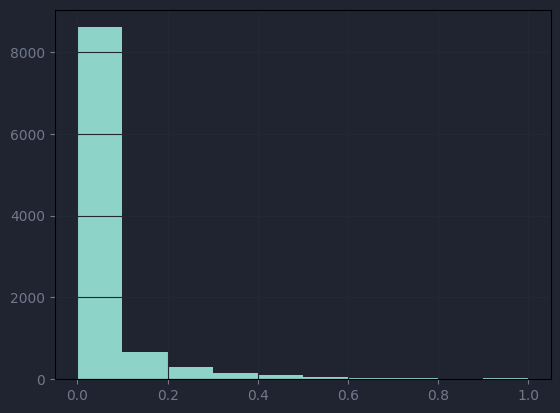

In [8]:
t.hist()

count    10000.000000
mean         0.199805
std          0.012564
min          0.153398
25%          0.191262
50%          0.200000
75%          0.207767
max          0.246602
dtype: float64


<Axes: >

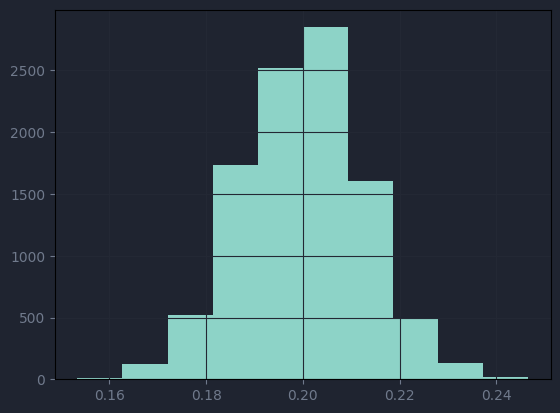

In [9]:
result_a = []
result_b = []

for _ in range(10000):
    mean_a = np.random.binomial(1, baseline, size=sample_size).mean()
    mean_b = np.random.binomial(1, baseline + mde, size=sample_size).mean()
    result_a.append(mean_a)
    result_b.append(mean_b)

result_a = pd.Series(result_a)
print(result_a.describe())
result_a.hist()

count    10000.000000
mean         0.249937
std          0.013310
min          0.200000
25%          0.240777
50%          0.249515
75%          0.259223
max          0.297087
dtype: float64


<Axes: >

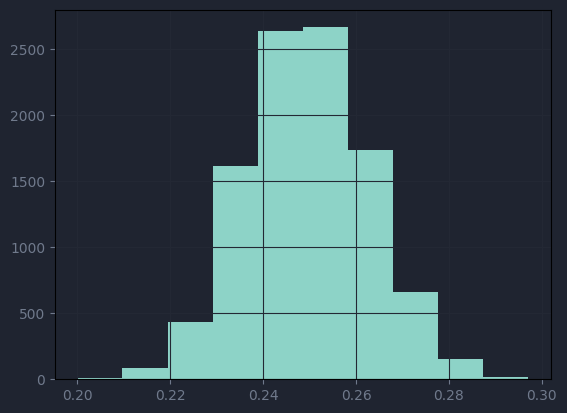

In [10]:
result_b = pd.Series(result_b)
print(result_b.describe())
result_b.hist()

In [11]:
result = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde, size=sample_size)
    _, pval = ttest_ind(a, b)
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
t_test = pd.Series(result)
(t_test < 0.05).mean()

np.float64(0.7763)

Для того, чтобы понять, что мы подобрали нужный тест, проведем АА тест для ttest и ztest:

In [13]:
result = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, pval = ttest_ind(a, b)
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
ttest_aa = pd.Series(result)

<Axes: ylabel='Proportion'>

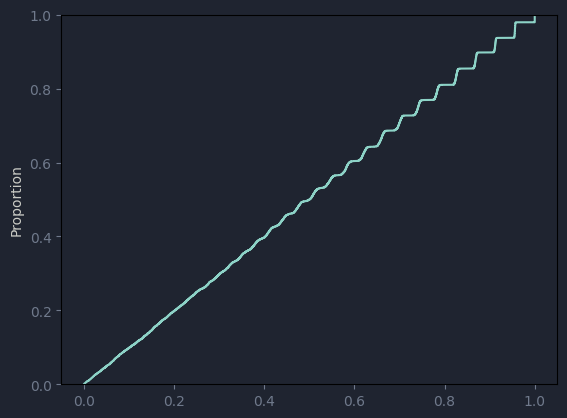

In [15]:
sns.ecdfplot(ttest_aa)

In [16]:
(ttest_aa < 0.05).mean()

np.float64(0.0483)

In [22]:
result = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline, size=sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
ztest_aa = pd.Series(result)

<Axes: ylabel='Proportion'>

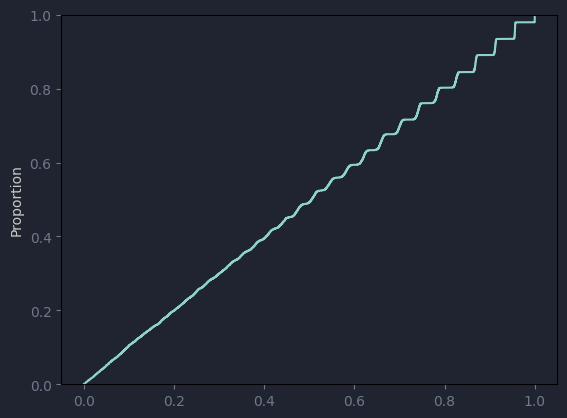

In [24]:
sns.ecdfplot(ztest_aa)

In [25]:
(ztest_aa < 0.05).mean()

np.float64(0.0504)

Для того, чтобы посчитать расчитать мощность более приближенную к 80, воспользуемся формулой:

In [30]:
import statsmodels.stats.api as sms

es = sms.proportion_effectsize(0.2, 0.25)
new_sample_size = round(
    sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
)

In [34]:
aa_result = []
ab_result = []

for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=new_sample_size)
    a_1 = np.random.binomial(1, baseline, size=new_sample_size)
    b = np.random.binomial(1, baseline + mde, size=new_sample_size)
    _, pval_aa = proportions_ztest([a.sum(), a_1.sum()], [len(a), len(a_1)])
    _, pval_ab = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    aa_result.append(pval_aa)
    ab_result.append(pval_ab)

ztest_aa = pd.Series(aa_result)
ztest_ab = pd.Series(ab_result)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: ylabel='Proportion'>

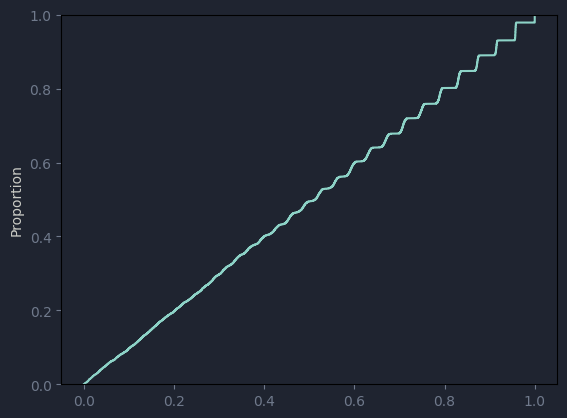

In [35]:
sns.ecdfplot(ztest_aa)

<Axes: ylabel='Proportion'>

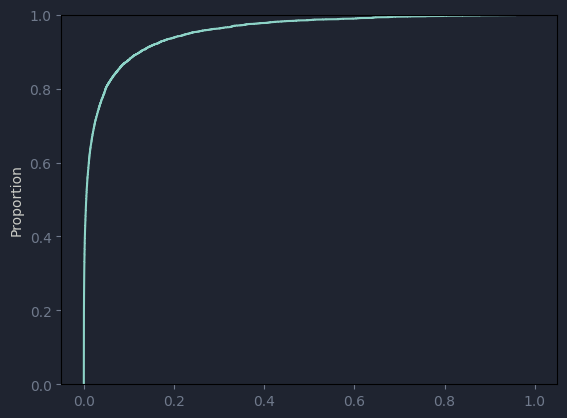

In [36]:
sns.ecdfplot(ztest_ab)

In [37]:
print((ztest_aa < 0.05).mean(), (ztest_ab < 0.05).mean())

0.0516 0.8041


Но что, если в реальности наши размеры групп разные(чаще всего так и происходит, поскольку тестовую группу набирать "дороже")? Например соотношение наблюдений в тесте к контролю = 1/3. Для этого воспользуемся расчетом можности теста по другой формуле:

In [38]:
import statsmodels.stats.api as sms

es = sms.proportion_effectsize(0.2, 0.25)
new_sample_size = round(
    sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1 / 3)
)

В данном случае `new_sample_size` - это размер большей группы

In [43]:
few_sample = int(new_sample_size / 3)

In [44]:
aa_result = []
ab_result = []

for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size=new_sample_size)
    a_1 = np.random.binomial(1, baseline, size=few_sample)
    b = np.random.binomial(1, baseline + mde, size=few_sample)
    _, pval_aa = proportions_ztest([a.sum(), a_1.sum()], [len(a), len(a_1)])
    _, pval_ab = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    aa_result.append(pval_aa)
    ab_result.append(pval_ab)

ztest_aa = pd.Series(aa_result)
ztest_ab = pd.Series(ab_result)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
print((ztest_aa < 0.05).mean(), (ztest_ab < 0.05).mean())

0.0462 0.8074


С помощью monte-Carlo можно подобрать размер группы, увеличивая sample_size итерационно:

In [55]:
sample_size = 8500
baseline = 0.3
mde = 0.02
result = []

for _ in tqdm(range(1000)):
    a = np.random.binomial(1, baseline, size=sample_size)
    b = np.random.binomial(1, baseline + mde, size=sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])
    result.append(pval)

t = pd.Series(result)
(t < 0.05).mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

np.float64(0.801)

In [53]:
import statsmodels.stats.api as sms

es = sms.proportion_effectsize(baseline, baseline + mde)
new_sample_size = round(
    sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
)
new_sample_size

8392